## Feature Selection using PCA


In [1]:
import pylab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import statsmodels.api as sm

In [2]:
boston_df = pd.read_csv('datasets/boston.csv')

boston_df.head()

,crime rate,residential land zone,business acres,Charles River,nitric oxides,number of rooms,age,distances to employment centres,accessibility to highways,property-tax,pupil-teacher ratio,lower income levels,Median Home Value
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,5.33,36.2


In [3]:
FEATURES = list(boston_df.columns[:-1])

FEATURES

['crime rate',
 'residential land zone',
 'business acres',
 'Charles River',
 'nitric oxides',
 'number of rooms',
 'age',
 'distances to employment centres',
 'accessibility to highways',
 'property-tax',
 'pupil-teacher ratio',
 'lower income levels']

In [19]:
len(FEATURES)

12

## Apply PCA
* PCA: Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space.
* explained_variance_ : The amount of variance explained by each of the selected components.
* components_ : Principal axes in feature space, representing the directions of maximum variance in the data.
* fit_transform : Fit the model with X and apply the dimensionality reduction on X

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [4]:
from sklearn.decomposition import PCA

def apply_pca(X, n, add_constant = False):
    
    pca = PCA(n_components = n)  
    x_new = pca.fit_transform(X)
    
    if add_constant is True:
        x_new = sm.add_constant(x_new)    
        
    return pca, pd.DataFrame(x_new)

In [5]:
pca, _ = apply_pca(boston_df[FEATURES], len(FEATURES))

In [7]:
print("Explained Variance:", pca.explained_variance_ratio_)

Explained Variance: [9.60040728e-01 2.73884414e-02 8.89341069e-03 1.72579506e-03
 9.36295702e-04 5.35816960e-04 3.19581712e-04 1.09868221e-04
 3.93666446e-05 8.58505778e-06 2.00834312e-06 1.02396314e-07]


In [8]:
sum(pca.explained_variance_ratio_)

1.0

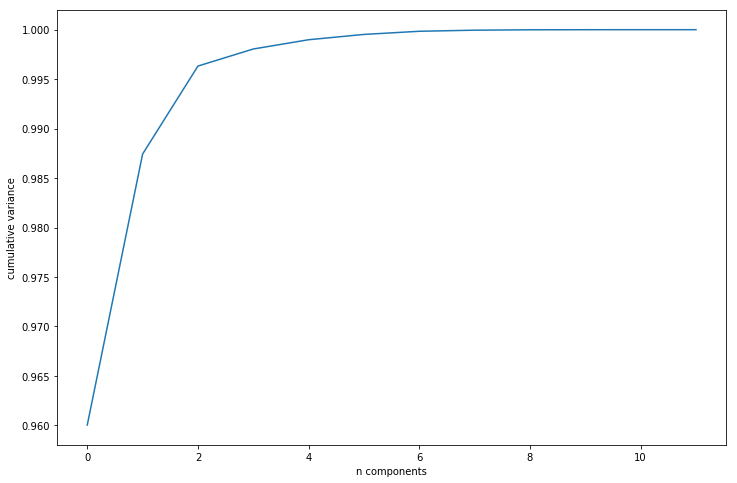

In [20]:
plt.figure(figsize = (12, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xlabel('n components')
plt.ylabel('cumulative variance');

## Build model

In [21]:
def build_model(regression_fn,                
                target, 
                features, 
                dataset,
                *hyperparameters):
    
    X = dataset[features]
    Y = dataset[target]

    _ , X_new = apply_pca(X, *hyperparameters)

    x_train, x_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.2)
    
    model = regression_fn(x_train, y_train)
    
    y_pred = model.predict(x_test) 
    
    return {
            'x_initial' : X,
            'x_transform': X_new,
            'x_train' : x_train,
            'x_test'  : x_test, 
            'y_train' : y_train,
            'y_test'  : y_test,
            'y_pred'  : y_pred,
            'model'   : model
           }     

In [22]:
def ols_reg(x_train, y_train):
    
    ols = sm.OLS(y_train, x_train)
    
    model = ols.fit()
    
    return model

In [23]:
def linear_reg(x_train, y_train):
    
    model = LinearRegression().fit(x_train, y_train)
    
    return model

## Statsmodel 

In [14]:
model_params = {}

In [24]:
model_params['statsmodel_reg'] = build_model(ols_reg,
                                            'Median Home Value',
                                            FEATURES,
                                            boston_df,
                                            6,
                                            True)

In [25]:
model       = model_params['statsmodel_reg']['model']
x_initial   = model_params['statsmodel_reg']['x_initial']
x_transform = model_params['statsmodel_reg']['x_transform']
x_train     = model_params['statsmodel_reg']['x_train']
x_test      = model_params['statsmodel_reg']['x_test']
y_train     = model_params['statsmodel_reg']['y_train']
y_test      = model_params['statsmodel_reg']['y_test']
y_pred      = model_params['statsmodel_reg']['y_pred']

### Visualize transformed results

In [26]:
x_transform.shape

(506, 7)

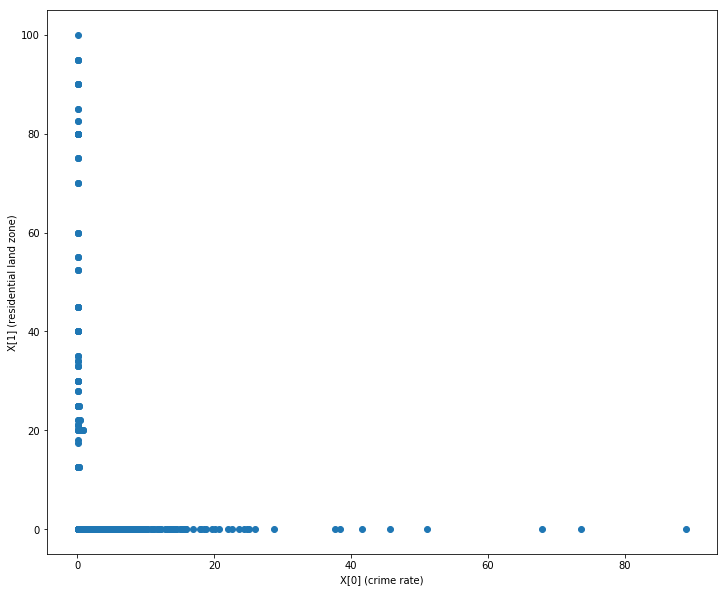

In [27]:
fig, ax = plt.subplots(figsize = (12,10))

ax.scatter(x_initial['crime rate'], x_initial['residential land zone'], cmap = 'Spectral')
plt.xlabel('X[0] (crime rate)')
plt.ylabel('X[1] (residential land zone)');

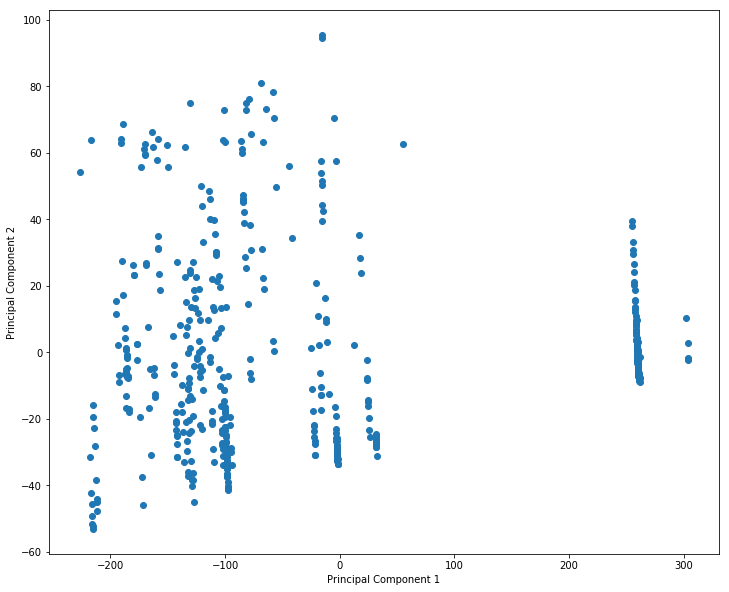

In [28]:
fig, ax = plt.subplots(figsize = (12,10))

ax.scatter(x_transform[1], x_transform[2], cmap = 'Spectral')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2');

In [29]:
print('Rsquared: ', model.rsquared)
print('Adjusted Rsquared: ', model.rsquared_adj)

Rsquared:  0.5878255241683413
Adjusted Rsquared:  0.5815961870021198


## Sklearn Model

In [32]:
model_params['sklearn_reg'] = build_model(linear_reg,
                                          'Median Home Value',
                                           FEATURES,
                                           boston_df,
                                           6)

In [33]:
model       = model_params['sklearn_reg']['model']
x_transform = model_params['sklearn_reg']['x_transform']
x_train     = model_params['sklearn_reg']['x_train']
x_test      = model_params['sklearn_reg']['x_test']
y_train     = model_params['sklearn_reg']['y_train']
y_test      = model_params['sklearn_reg']['y_test']
y_pred      = model_params['sklearn_reg']['y_pred']

In [34]:
x_transform.shape

(506, 6)

In [35]:
print('Training score: ', model.score(x_train, y_train))
print('Testing score: ', r2_score(y_test, y_pred))

Training score:  0.5991266411349765
Testing score:  0.5120368971344347
